#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())

base_dir = str(path.parent.parent)

data_in = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
data_out = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
output = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")

sys.path.append(func)
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

## PART I
#### Loading and preparing data 
----------------------------------------------
make sure you have run ch16-airbnb-prepare-london.ipynb before

In [3]:
area = "london"
data = pd.read_csv(data_in + "airbnb_" + area + "_workfile_adj.csv")
data = data.loc[lambda x: x["price"].notna()]

In [4]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

#### Sample definition and preparation
--------------
We focus on normal apartments, n<8

In [5]:
data = data.loc[lambda x: x["n_accommodates"] < 8]

#### Basic descriptive stats
-------------------------------------------

In [6]:
data.describe()

,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.00000,49826.000000,49826.000000,...,49826.000000,49826.000000,49826.000000,49826.0,49826.000000,49826.000000,49826.000000,4.982600e+04,4.982600e+04,49826.000000
mean,88.984044,2.838759,1.224260,92.458616,12.340144,1.356180,1.138253,6.50873,3.300947,1.585959,...,0.303998,0.318850,0.303998,0.0,5.713297,33.456371,199.607207,2.931985e+05,3.046539e+08,4.520910
std,70.515089,1.494748,0.466448,8.418474,25.889935,0.879263,1.238156,12.31549,29.578062,0.927501,...,0.459986,0.466035,0.459986,0.0,0.902564,9.506988,80.264045,5.640361e+05,9.636140e+08,0.120421
min,8.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.010000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732
25%,41.000000,2.000000,1.000000,92.000000,0.000000,1.000000,0.470000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,5.433722,29.525335,160.432461,5.198400e+04,1.185235e+07,4.521789
50%,70.000000,2.000000,1.000000,94.000000,3.000000,1.000000,0.770000,0.00000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,5.793014,33.559007,194.407782,1.069290e+05,3.496578e+07,4.543295
75%,110.000000,4.000000,1.000000,97.000000,12.000000,1.000000,1.170000,10.00000,3.000000,2.000000,...,1.000000,1.000000,1.000000,0.0,6.224558,38.745128,241.171311,2.540160e+05,1.280241e+08,4.574711
max,999.000000,7.000000,8.000000,100.000000,396.000000,16.000000,15.000000,240.00000,5000.000000,16.000000,...,1.000000,1.000000,1.000000,0.0,7.909489,62.560024,494.817853,7.409284e+06,2.016807e+10,4.605170


In [7]:
data["price"].describe()

count    49826.000000
mean        88.984044
std         70.515089
min          8.000000
25%         41.000000
50%         70.000000
75%        110.000000
max        999.000000
Name: price, dtype: float64

In [8]:
data["f_room_type"].value_counts()

f_room_type
Entire home/apt    24938
Private room       24351
Shared room          537
Name: count, dtype: int64

In [9]:
data["f_property_type"].value_counts()

f_property_type
Apartment    37467
House        12359
Name: count, dtype: int64

In [10]:
data["f_number_of_reviews"].value_counts()

f_number_of_reviews
1    31576
0    15147
2     3103
Name: count, dtype: int64

### Create train and holdout samples
-------------------------------------------

train is where we do it all, incl CV

In [11]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [12]:
data_train.shape, data_holdout.shape

((34878, 91), (14948, 91))

In [13]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [14]:
PREDICTORS_1 = basic_vars
PREDICTORS_2 = basic_vars + reviews + amenities
PREDICTORS_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

**Note:** n_estimators=500 in the R code.

Here, we set it to 30 because the model runs mutch faster, and this does not change the results substantively here – however in other cases might.

In [15]:
N_CORES = 7  # set number of cores in your machine to run the code in parallel
N_CV = 5  # number of cross-validation folds
RANDOM_STATE = 42  # set random seed for reproducibility

Model A: Basic Variables

In [16]:
CATEGORICAL_COLUMNS = [col for col in PREDICTORS_1 if col.startswith("f_")]
N_ESTIMATORS = 50
TUNE_GRID = {"max_features": [5, 7, 9], "min_samples_split": [6, 11]}

rf_model_1 = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("cat", OneHotEncoder(drop=None), CATEGORICAL_COLUMNS)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        (
            "model",
            GridSearchCV(
                RandomForestRegressor(
                    n_estimators=N_ESTIMATORS,
                    criterion="squared_error",
                    oob_score=True,
                    n_jobs=N_CORES,
                    random_state=RANDOM_STATE,
                ),
                TUNE_GRID,
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                n_jobs=N_CORES,
                verbose=3,
            ),
        ),
    ],
    verbose=True,
)
rf_model_1 = rf_model_1.fit(data_train[PREDICTORS_1], data_train["price"])

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Pipeline] ............. (step 2 of 2) Processing model, total=  21.6s


Model B: Basic Variables + Reviews + Amenities

In [17]:
CATEGORICAL_COLUMNS = [col for col in PREDICTORS_2 if col.startswith("f_")]
N_ESTIMATORS = 50
TUNE_GRID = {"max_features": [8, 10, 12], "min_samples_split": [6, 11, 16]}

rf_model_2 = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("cat", OneHotEncoder(drop=None), CATEGORICAL_COLUMNS)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        (
            "model",
            GridSearchCV(
                RandomForestRegressor(
                    n_estimators=N_ESTIMATORS,
                    criterion="squared_error",
                    oob_score=True,
                    n_jobs=N_CORES,
                    random_state=RANDOM_STATE,
                ),
                TUNE_GRID,
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                n_jobs=N_CORES,
                verbose=3,
            ),
        ),
    ],
    verbose=True,
)
rf_model_2 = rf_model_2.fit(data_train[PREDICTORS_2], data_train["price"])

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Pipeline] ............. (step 2 of 2) Processing model, total=   7.1s


### Table 16.1 Random forest RMSE by tuning parameters

In [18]:
(
    pd.DataFrame(rf_model_2[1].cv_results_)[
        ["param_max_features", "param_min_samples_split", "mean_test_score"]
    ]
    .assign(
        mean_test_score=lambda x: x["mean_test_score"] * -1,
        Variables=lambda x: x["param_max_features"],
        Min_nodes=lambda x: x["param_min_samples_split"] - 1,
    )
    .pivot(index="Min_nodes", columns="Variables", values="mean_test_score")
    .round(2)
)

Variables,8,10,12
Min_nodes,,,
5,44.30,44.21,44.08
10,44.52,44.34,44.22
15,44.70,44.51,44.38


In [19]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_1[1].best_estimator_.max_features,
            rf_model_2[1].best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_1[1].best_estimator_.min_samples_split - 1,
            rf_model_2[1].best_estimator_.min_samples_split - 1,
        ],
    },
    ["Model A", "Model B"],
)

,Min vars,Min nodes
Model A,5,10
Model B,12,5


In [20]:
rf_model_1_rmse = rf_model_1[1].cv_results_["mean_test_score"].max() * -1
rf_model_2_rmse = rf_model_2[1].cv_results_["mean_test_score"].max() * -1

pd.DataFrame(
    {"RMSE": [rf_model_1_rmse, rf_model_2_rmse]}, ["Model A", "Model B"]
).round(2)

,RMSE
Model A,46.64
Model B,44.08


## PART III
### MODEL DIAGNOSTICS 
---

### Variable importance

In [21]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        [
            rf_model_2[1].best_estimator_.feature_importances_,
            rf_model_2[0].get_feature_names_out(),
        ],
        index=["imp", "varname"],
    )
    .T.assign(
        factor=lambda x: x["varname"].str.startswith("f_"),
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type_", "Room type: ", regex=False
        )
        .str.replace("f_neighbourhood_cleansed_", "Borough: ", regex=False)
        .str.replace("f_cancellation_policy_", "Cancelation policy: ", regex=False)
        .str.replace("f_bed_type_", "Bed type: ", regex=False)
        .str.replace("f_property_type_", "Property type: ", regex=False)
        .str.replace("f_bathroom_0", "No bathroom")
        .str.replace("f_bathroom_1", "One bathroom")
        .str.replace("f_bathroom_2", "More than 1 bathroom"),
    )
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

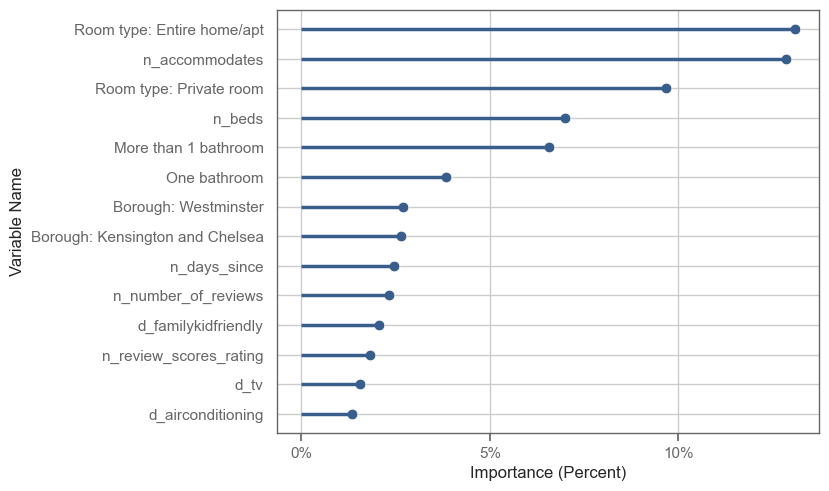

In [22]:
cutoff = 0.013

plot_df = rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff]
da.plot_variable_importance(plot_df)

**2) full varimp plot, top 10 only**

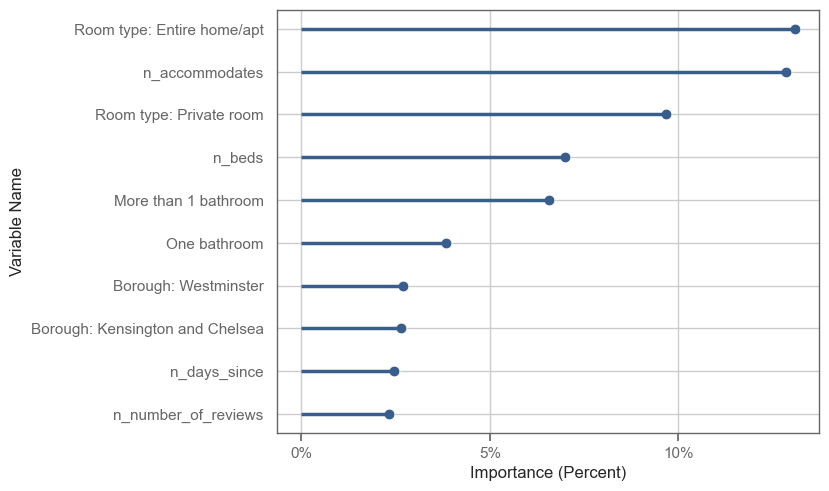

In [23]:
plot_df = rf_model_2_var_imp_df.head(10)
da.plot_variable_importance(plot_df)

#### 3) grouped variable importance - keep binaries created off factors together

First we do this by summing up the individual importances of factors - this is not correct, but it's in the first edition.

Simply summing up the individual importances of each dummy could underestimate the importance of the qualitative variable. This occurs because omitting a single category might not significantly impact performance as the remaining correlated categories can still provide the model with the necessary information. 

To address this issue, we need to assess the impact of including the entire categorical variable, not just the individual dummies. We create a pipeline which first encodes the categorical variables into dummy variables, then trains the model on the encoded data. Finally, we can employ a model-agnostic feature importance technique on this entire pipeline to estimate the contribution of each variable. This way, one categorical variableis either included or not during the calculation of variable importances.
 
Model-agnostic feature importance techniques are methods used to determine the importance of features in a model, regardless of the model type. These techniques work by assessing the impact of each feature on the model's predictions without relying on the internal workings of the model. One such technique is permutation feature importance, which randomly shuffles the values of variables and measures how much the fit of the prediction is decreased.

In [24]:
rf_model_2_var_imp_df_grouped = (
    pd.DataFrame(
        [
            rf_model_2[1].best_estimator_.feature_importances_,
            rf_model_2[0].get_feature_names_out(),
        ],
        index=["imp", "varname"],
    )
    .T.assign(
        varname=lambda x: np.where(
            x["varname"].str.contains("f_"),
            x["varname"].str.split("_").str[:-1].str.join("_"),
            x["varname"],
        )
    )
    .groupby("varname")[["imp"]]
    .sum()
    .reset_index()
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
)

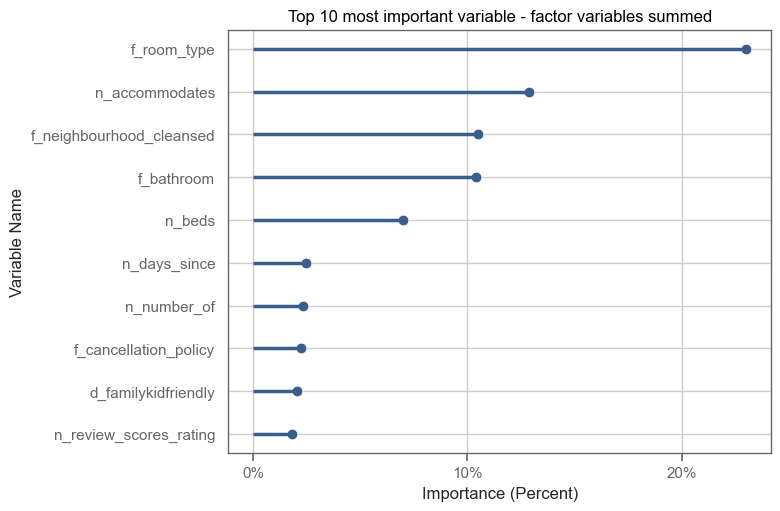

In [25]:
plot_df = rf_model_2_var_imp_df_grouped.sort_values(by=["imp"], ascending=False).head(
    10
)
da.plot_variable_importance(
    plot_df, title="Top 10 most important variable - factor variables summed"
)

**OneHotEncoding and training the RandomForest model in a pipeline and calculating permutation importance - second edition**

In [26]:
# This takes a while
result = permutation_importance(
    rf_model_2,
    data_train[PREDICTORS_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [27]:
grouped_imp = pd.DataFrame(
    [result.importances_mean, data_train[PREDICTORS_2].columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

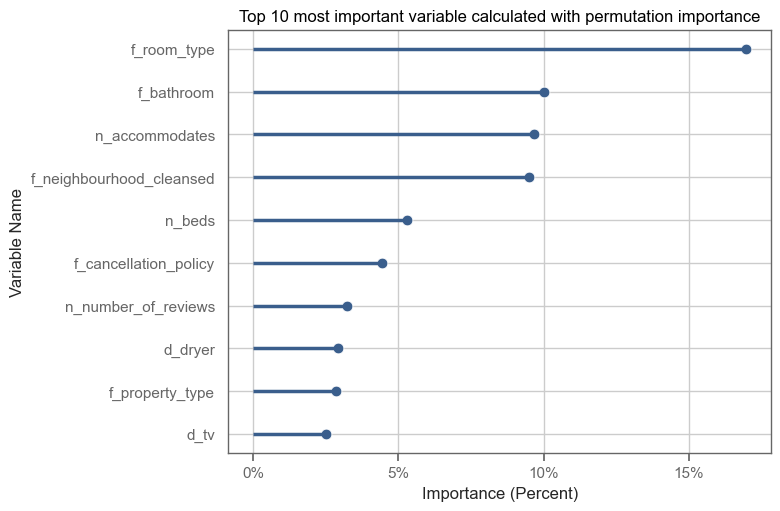

In [28]:
plot_df = grouped_imp.sort_values(by=["imp"], ascending=False).head(10)
da.plot_variable_importance(
    plot_df,
    title="Top 10 most important variable calculated with permutation importance",
)

### Partial Dependence Plots without and with ICE plot overlay

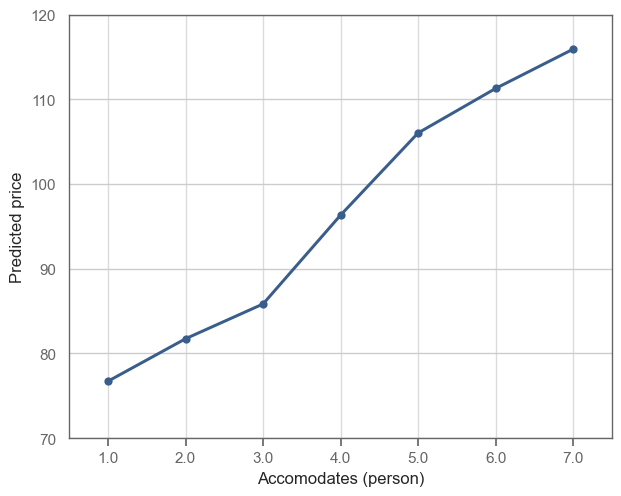

In [29]:
da.plot_partial_dependence(
    rf_model_2,
    data_holdout[PREDICTORS_2],
    "n_accommodates",
    "Accomodates (person)",
)

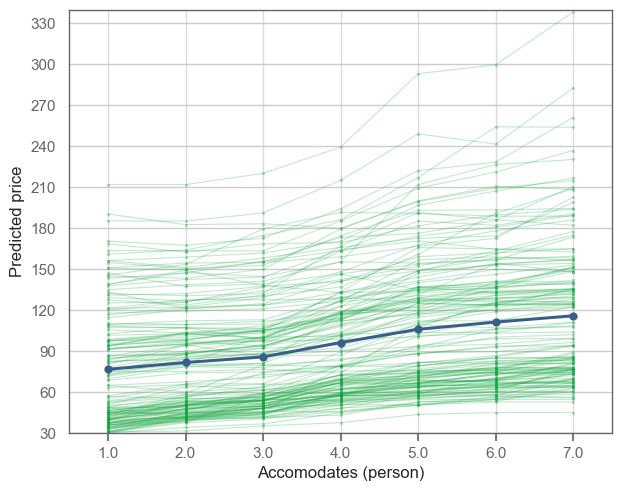

In [ ]:
# Note: Only 1% of all ICE curves are plotted to avoid overcrowding the chart
da.plot_partial_dependence(
    rf_model_2,
    data_holdout[PREDICTORS_2],
    "n_accommodates",
    "Accomodates (person)",
    kind="both"
)

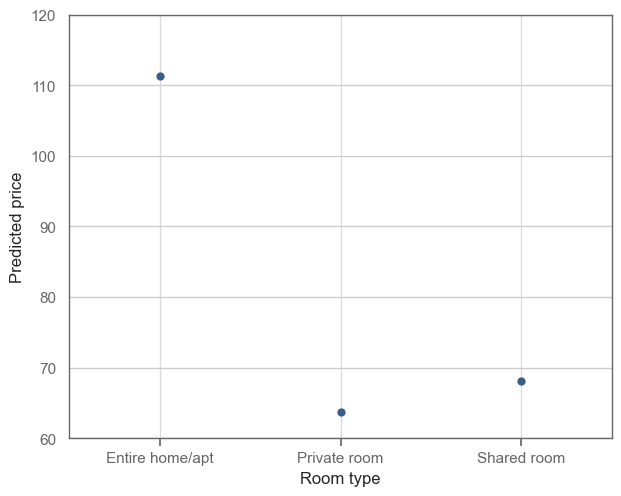

In [31]:
da.plot_partial_dependence(
    rf_model_2, data_holdout[PREDICTORS_2], "f_room_type", "Room type"
)

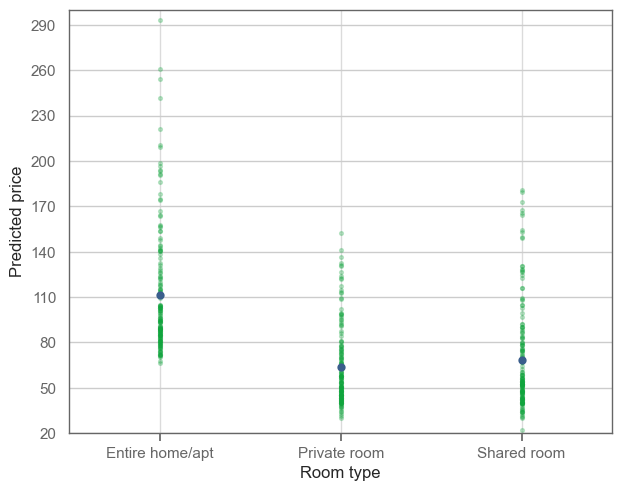

In [ ]:
# Note: Only 1% of all ICE curves are plotted to avoid overcrowding the chart
da.plot_partial_dependence(
    rf_model_2, data_holdout[PREDICTORS_2], "f_room_type", "Room type", kind="both"
)

### Subsample performance: RMSE / mean(y) 

NOTE  we do this on the holdout set.


In [31]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_model_2.predict(data_holdout[PREDICTORS_2])
)

create nice summary table of heterogeneity

In [32]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: root_mean_squared_error(x.predicted_price, x.price),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )

In [33]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [34]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [35]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [36]:
all_holdout = (
    pd.DataFrame(
        [
            root_mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]

In [37]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

#### Table 16.2 Performance across subsamples

In [38]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,65.42,144.06,0.45
small apt,30.96,62.86,0.49
Type,,,
Apartment,43.2,93.19,0.46
House,50.38,77.49,0.65
Borough,,,
Camden,52.49,105.01,0.5
Hackney,38.54,76.05,0.51
Kensington and Chelsea,66.13,143.55,0.46


### Lime


In [ ]:
continous_and_ordinal_vars = [col for col in PREDICTORS_2 if col.startswith("n_")]
categorical_vars = [col for col in PREDICTORS_2 if not col.startswith("n_")]

In [ ]:
encoder = ColumnTransformer(
    [("c", OrdinalEncoder(), categorical_vars)],
    remainder="passthrough",
    verbose_feature_names_out=False,
).fit(data_train[PREDICTORS_2])

X_train_lime = pd.DataFrame(
    encoder.transform(data_train[PREDICTORS_2]), columns=encoder.get_feature_names_out()
)
X_holdout_lime = pd.DataFrame(
    encoder.transform(data_holdout[PREDICTORS_2]),
    columns=encoder.get_feature_names_out(),
)

numerical_indices = [
    X_train_lime.columns.get_loc(col) for col in continous_and_ordinal_vars
]
categorical_indices = [X_train_lime.columns.get_loc(col) for col in categorical_vars]

categorical_names = {
    idx: cat
    for idx, cat in zip(categorical_indices, encoder.transformers_[0][1].categories_)
}

In [ ]:
rf_best_pipeline = Pipeline(
    [
        (
            "preprocess",
            ColumnTransformer(
                [("cat", OneHotEncoder(), categorical_indices)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        ("regressor", rf_model_2[1].best_estimator_),  # best model
    ]
)

In [ ]:
rf_best_pipeline.fit(X_train_lime, data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_split=6,
                                       n_estimators=50, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [ ]:
predict_fn = lambda x: rf_best_pipeline.predict(x).astype(float)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_holdout_lime.to_numpy(),
    feature_names=X_holdout_lime.columns.tolist(),
    categorical_features=categorical_indices,
    categorical_names=categorical_names,
    mode="regression",
    random_state=1237,
)

In [ ]:
instance = X_holdout_lime.iloc[[2]]

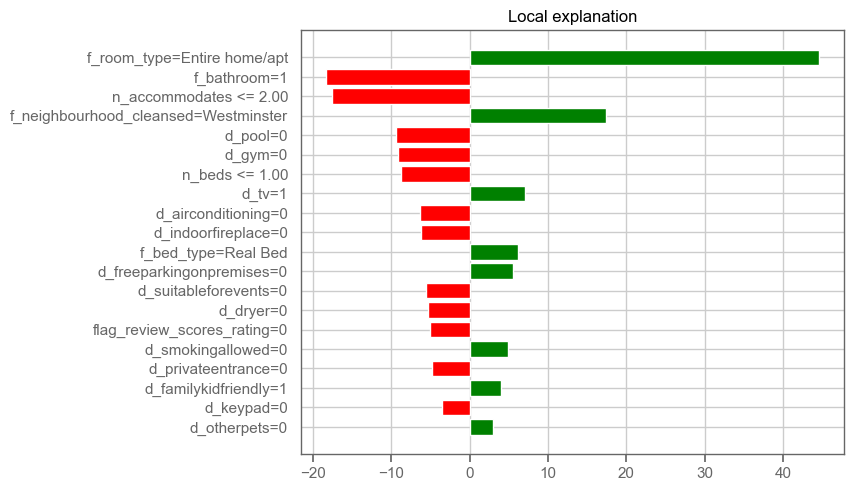

In [ ]:
from sklearn.linear_model import Ridge

exp = explainer.explain_instance(
    instance.to_numpy()[0],
    predict_fn,
    num_features=20,
    num_samples=1000,
    distance_metric="euclidean",
    model_regressor=Ridge(
        alpha=1, fit_intercept=True, random_state=explainer.random_state
    ),
)

exp.as_pyplot_figure()
plt.show()

In [ ]:
exp.predicted_value

94.0162554112554

In [ ]:
exp.local_pred[0]

109.67430484586674

In [ ]:
exp.intercept[0]

117.02182186168598

In [ ]:
sum([i[1] for i in exp.as_list()])

-7.347517015819234

### SHAP

In [39]:
import shap

Calculate SHAP values for our best model

Since shap does not accept categorical values, we do the encoding before passing the matrix to shap

**NOTE:** Again, we do this on the holdout set!

In [40]:
X_holdout = pd.DataFrame(
    rf_model_2[0].transform(data_holdout[PREDICTORS_2]),
    columns=rf_model_2[0].get_feature_names_out(),
)

In [41]:
explainer = shap.Explainer(rf_model_2[1].predict, X_holdout, seed=RANDOM_STATE)
shap_values = explainer(X_holdout)

PermutationExplainer explainer: 14949it [36:34,  6.80it/s]                            


#### Beeswarm plot of SHAP values

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature row. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature. In the plot below we can see that Entire home/apt is the most important feature on average, and than Entire home/apt-s are more expensive.



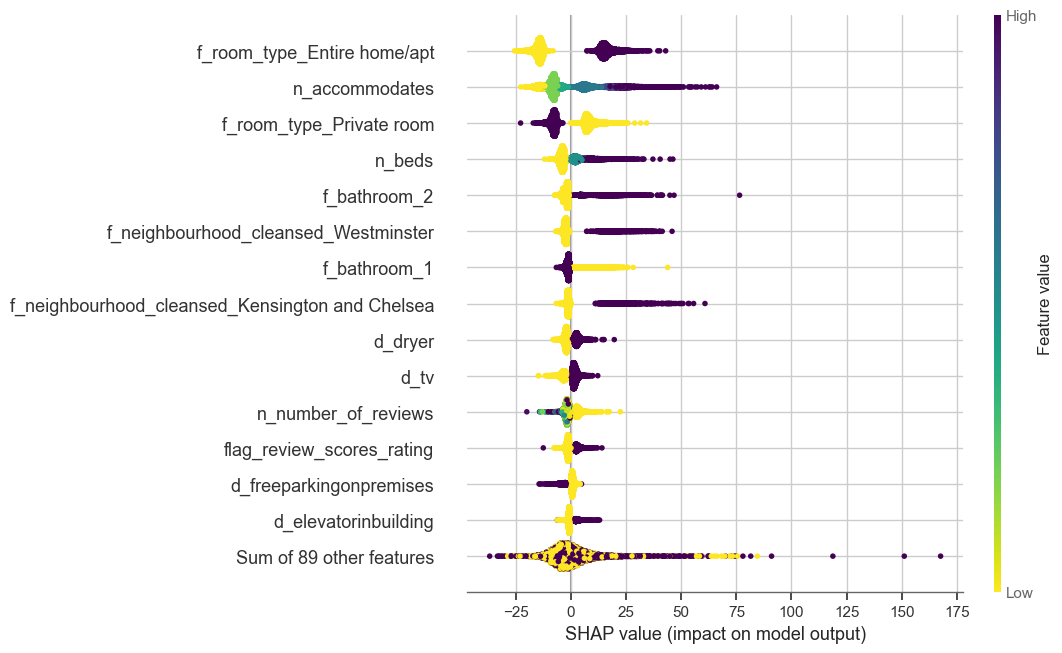

In [42]:
shap.plots.beeswarm(
    shap_values, max_display=15, color=plt.get_cmap("viridis_r"), show=True
)

Can do the same with **SHAP values scaled log**. This might come handy, when the distribution of SHAP values are skewed

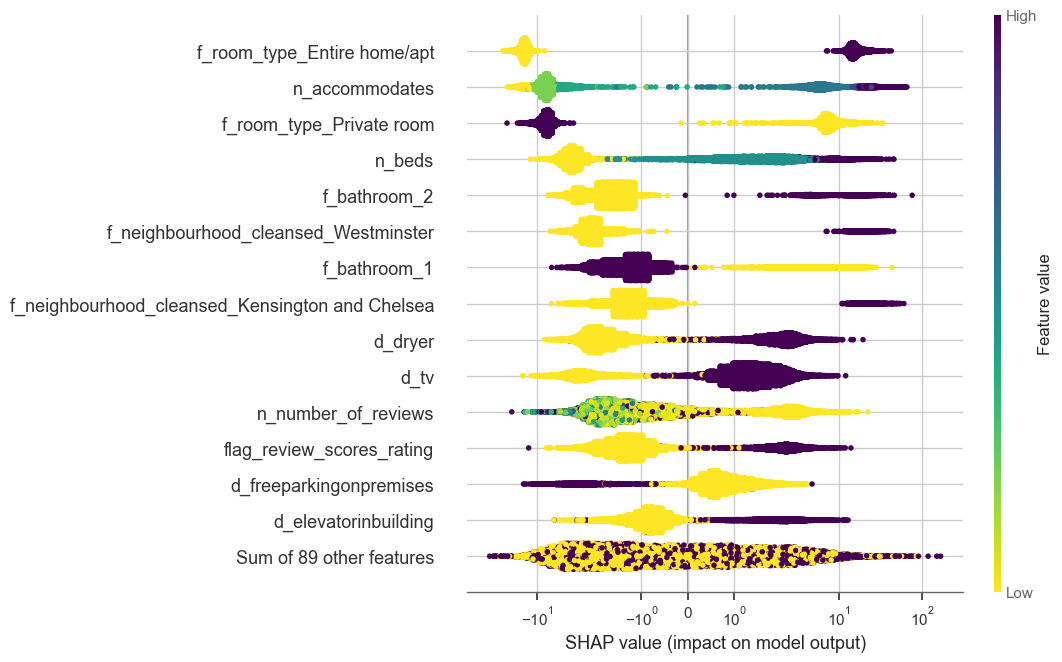

In [43]:
shap.plots.beeswarm(
    shap_values, max_display=15, log_scale=True, color=plt.get_cmap("viridis_r")
)

You can also display the **SHAP values in absolute**, on a beeswarm plot

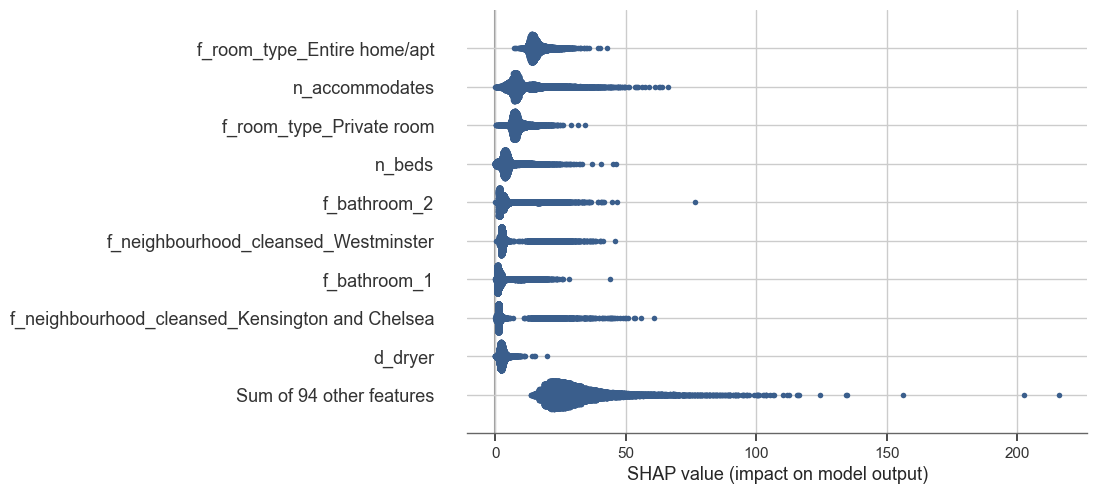

In [44]:
shap.plots.beeswarm(shap_values.abs, color=da.color[0])

Or on a barplot

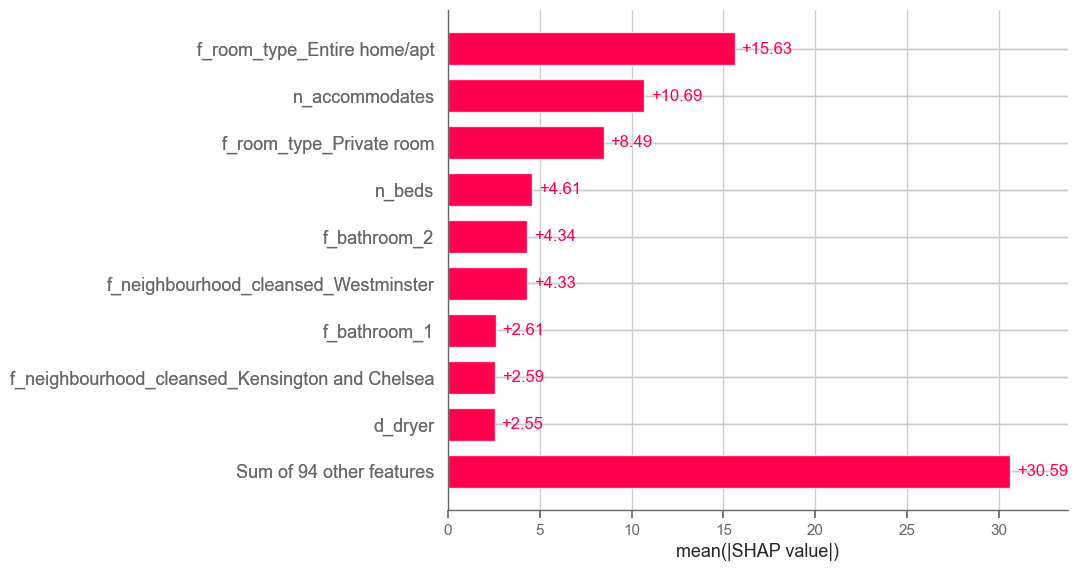

In [45]:
shap.plots.bar(shap_values)

#### Explanining predictions for a unit of observation (airbnb)

Let's look at SHAP values for the third observation in the holdout set. 

- .values array contains the shap values
- .base_values contains the expected value (intercept/constant in OLS terms)
- .data contains the feature values for the observation

In [46]:
shap_values[2]

.values =
array([-6.13296432e-01, -4.16656451e-01,  1.47726262e+01,  8.19960649e+00,
        0.00000000e+00,  2.13903175e-02, -1.40861769e+00, -3.68882779e+00,
        9.05325921e-01, -3.68341105e-01, -1.88078508e+00,  2.45420382e-02,
        3.61511454e-02,  4.65000000e-03, -1.24339466e-02,  0.00000000e+00,
        3.06885426e-02, -3.83553571e-03, -2.31767746e-01,  0.00000000e+00,
        4.53355556e-02,  7.00519841e-03,  2.21488095e-03,  0.00000000e+00,
        3.33561517e-02, -1.02102680e-01,  6.10911003e-02,  0.00000000e+00,
        0.00000000e+00,  1.30386905e-02, -4.23502489e-02, -1.20418669e-02,
       -8.42413852e-01,  0.00000000e+00,  2.64384513e-02,  5.01662680e-02,
       -4.33762157e-02,  2.70246320e-02, -1.57500000e-03, -1.16189131e-01,
        1.64623834e-02,  0.00000000e+00,  1.05247814e-01,  5.37623304e-02,
       -3.77330862e-02,  1.70053610e+01, -8.69919702e+00, -4.63491018e+00,
       -1.30979849e-01, -1.93971145e+00,  0.00000000e+00, -4.21311687e+00,
       -1.78118

#### Waterfall plot
The waterfall plot shows how the sum of all the SHAP values equals the difference between the prediction $f(x)$ and the expected value $E[f(x)]$. Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

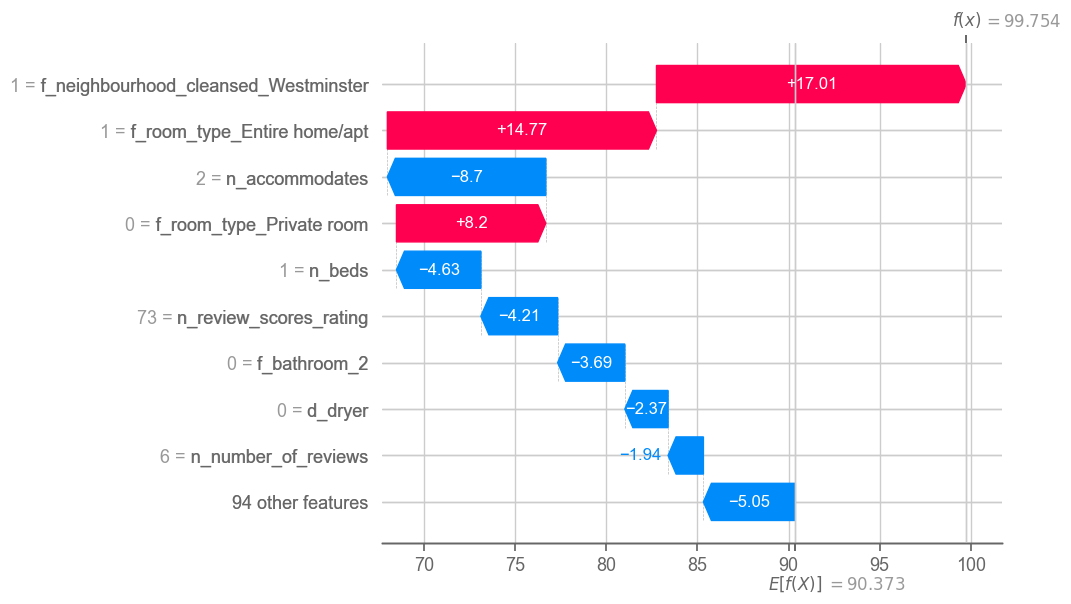

In [47]:
shap.plots.waterfall(shap_values[2])

Same plot, but SHAP values for another observation below.

Note, that for a same predictor (eg. f_room_type_Private room = 0) the SHAP values are different for the airbnb above (+5.29) and above (+6.88).

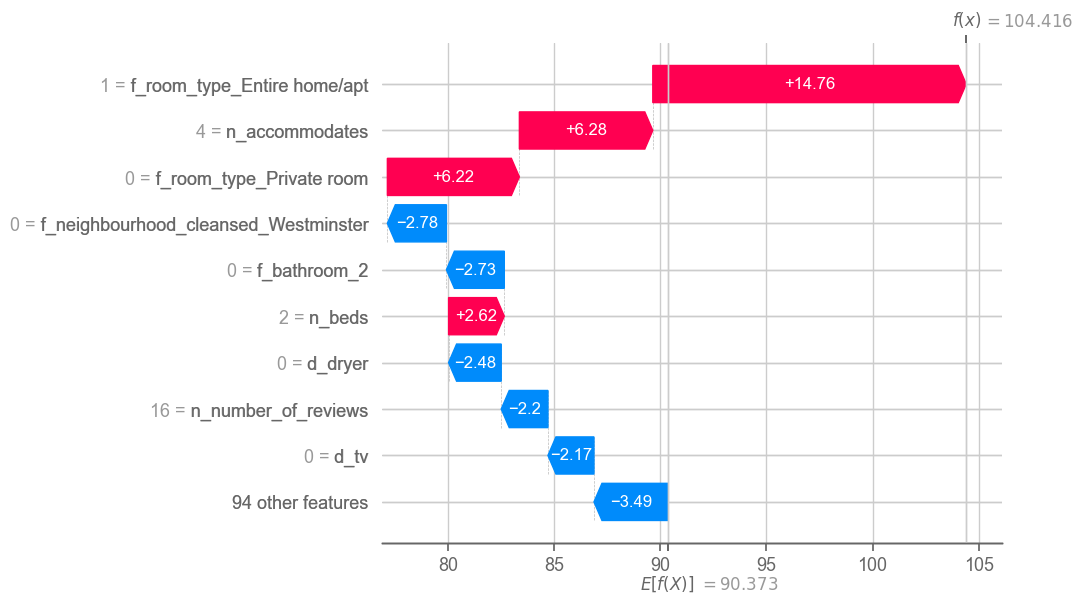

In [48]:
shap.plots.waterfall(shap_values[3])

### Interactions

Look at interactions from `ch14-airbnb-reg`

In [62]:
(
    "f_room_type*d_familykidfriendly",
    "f_room_type*f_property_type",
    "f_property_type*d_airconditioning",
    "f_property_type*d_cats",
    "f_property_type*d_dogs",
)

('f_room_type*d_familykidfriendly',
 'f_room_type*f_property_type',
 'f_property_type*d_airconditioning',
 'f_property_type*d_cats',
 'f_property_type*d_dogs')

To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument **the scatter plot will pick the best feature to color by.**

Get best proposed interaction by SHAP values for room types. Note that the grey area on the plot corresponds to the distribution of the feature in the data.

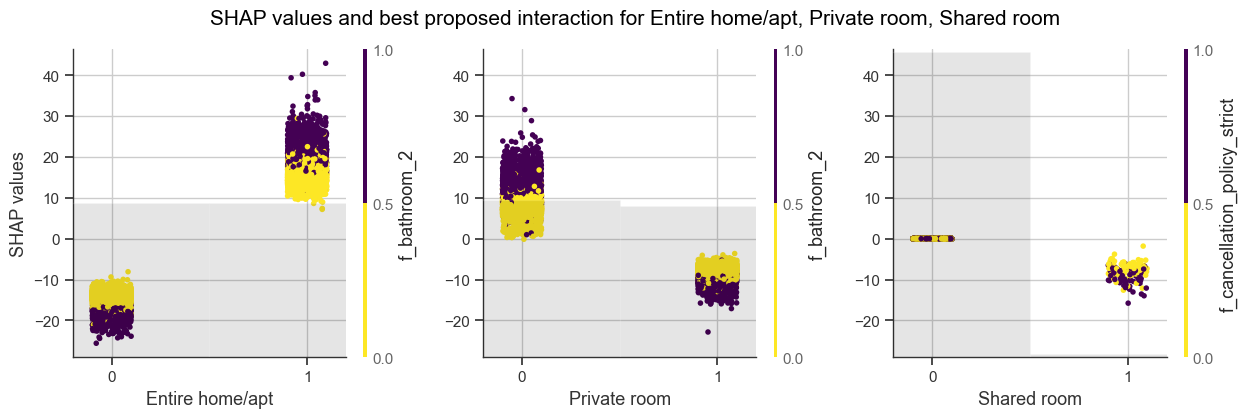

In [63]:
room_types = [
    ("f_room_type_Entire home/apt", "Entire home/apt"),
    ("f_room_type_Private room", "Private room"),
    ("f_room_type_Shared room", "Shared room"),
]

da.plot_shap_interactions(room_types, shap_values)

It turned out, that for the `f_room_type` variable the best interaction (at least based on RF and SHAP) would be the `f_bathroom` which we did not choose in ch14.

Let's check for `d_airconditioning`, `d_dogs` and `d_cats`.

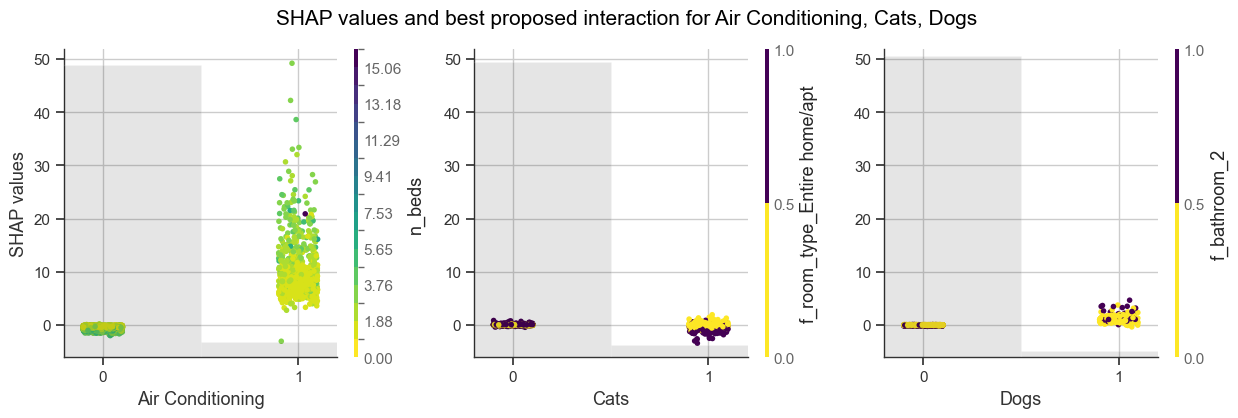

In [64]:
features = [
    ("d_airconditioning", "Air Conditioning"),
    ("d_cats", "Cats"),
    ("d_dogs", "Dogs"),
]

da.plot_shap_interactions(features, shap_values)

Take a look at a discrete feature, `n_accommodates`

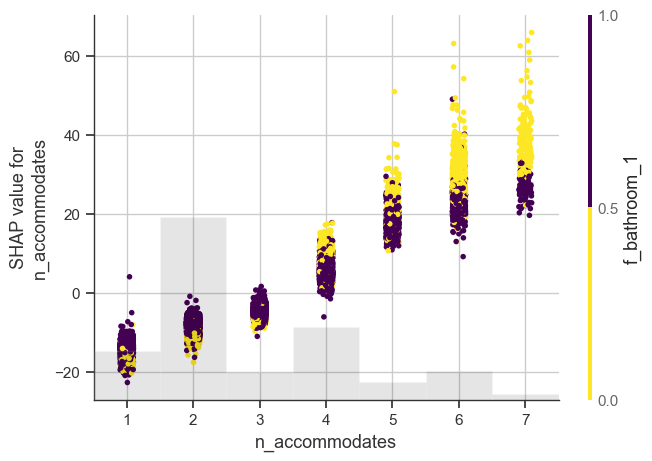

In [65]:
shap.plots.scatter(
    shap_values[:, "n_accommodates"], color=shap_values, cmap=plt.get_cmap("viridis_r")
)

## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------

1. OLS with dummies for area

 using model B

In [66]:
def get_cv_score(model):
    return min(model.cv_results_["mean_test_score"] * -1)

In [67]:
ols_model_cv = Pipeline(
    [
        (
            "encoding",
            ColumnTransformer(
                [("cat", OneHotEncoder(drop="first"), CATEGORICAL_COLUMNS)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        (
            "model",
            GridSearchCV(
                LinearRegression(),
                {},
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                verbose=3,
            ),
        ),
    ]
)

In [68]:
ols_model_cv.fit(data_train[PREDICTORS_2], data_train["price"])
ols_rmse = get_cv_score(ols_model_cv[1])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................................., score=-47.827 total time=   1.7s
[CV 2/5] END ................................., score=-46.831 total time=   3.2s
[CV 3/5] END ................................., score=-47.234 total time=   3.6s
[CV 4/5] END ................................., score=-45.627 total time=   2.9s
[CV 5/5] END ................................., score=-48.300 total time=   1.4s


In [69]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model_cv[1].best_estimator_.coef_.tolist(),
    index=ols_model_cv[0].get_feature_names_out(),
    columns=["ols_coefficient"],
).round(1)

In [70]:
ols_model_coeffs_df

,ols_coefficient
f_property_type_House,6.8
f_room_type_Private room,-35.4
f_room_type_Shared room,-45.0
f_bathroom_1,0.6
f_bathroom_2,30.1
...,...
d_tv,6.1
d_washer,-4.6
d_washerdryer,73.4
d_wheelchairaccessible,-2.0


2.  LASSO

using extended model w interactions

In [71]:
lasso_model_cv = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            GridSearchCV(
                Lasso(fit_intercept=True, random_state=RANDOM_STATE),
                {"alpha": np.arange(0.01, 0.26, 0.01)},
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                verbose=3,
                n_jobs=N_CORES,
            ),
        ),
    ]
)

In [72]:
y, X = dmatrices(
    "price ~ " + " + ".join(PREDICTORS_E), data_train, return_type="dataframe"
)
lasso_model_cv.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GridSearchCV(cv=5, estimator=Lasso(random_state=42), n_jobs=7,
                              param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25])},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))])

In [73]:
lasso_rmse = get_cv_score(lasso_model_cv[1])

In [74]:
pd.DataFrame(
    lasso_model_cv[1].best_estimator_.coef_.tolist(),
    index=X.columns,
    columns=["lasso_coefficient"],
).loc[lambda x: x.lasso_coefficient != 0].round(3)

,lasso_coefficient
f_room_type[T.Private room],-17.522
f_room_type[T.Shared room],-4.594
f_cancellation_policy[T.moderate],-0.509
f_cancellation_policy[T.strict],2.361
f_bed_type[T.Real Bed],0.488
...,...
d_tv,2.770
d_washer,-1.607
d_washerdryer,2.292
d_wheelchairaccessible,-0.216


3. CART model

In [75]:
preprocessor = ColumnTransformer(
    [("cat", OneHotEncoder(), CATEGORICAL_COLUMNS)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [76]:
X = preprocessor.fit_transform(data_train[PREDICTORS_2])
y = data_train["price"]

In [77]:
cart_model = DecisionTreeRegressor(random_state=2018)

In [78]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y)

In [79]:
# apply random search to select a "best" alpha
# RandomizedSearchCV does not calculate all potential alphas, just a random subset of 100 alphas

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": path["ccp_alphas"][:-1]},
    cv=N_CV,
    n_iter=100,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=N_CORES,
)


cart_model_cv.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2018),
                   n_iter=100, n_jobs=7,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.38777878e-17, 3.25811009e-06, ...,
       7.73465642e+01, 9.11800480e+01, 5.96312680e+02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [80]:
cart_rmse = get_cv_score(cart_model_cv)

4. GBM

**NOTE:** These models run for a **very long time**

In [81]:
TUNE_GRID = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("cat", OneHotEncoder(drop=None), CATEGORICAL_COLUMNS)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        (
            "model",
            GridSearchCV(
                GradientBoostingRegressor(
                    learning_rate=0.1,
                    criterion="squared_error",
                    min_samples_split=20,
                    random_state=RANDOM_STATE,
                ),
                TUNE_GRID,
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                n_jobs=N_CORES,
                verbose=3,
            ),
        ),
    ],
    verbose=True,
)
gbm_model_cv = gbm_model_cv.fit(data_train[PREDICTORS_2], data_train["price"])

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Pipeline] ............. (step 2 of 2) Processing model, total=74.2min


In [82]:
gbm_rmse = get_cv_score(gbm_model_cv[1])

the next will be in final model, loads of tuning

In [ ]:
TUNE_GRID = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}


gbm_model_cv_broad = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("cat", OneHotEncoder(drop=None), CATEGORICAL_COLUMNS)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        (
            "model",
            GridSearchCV(
                GradientBoostingRegressor(
                    criterion="squared_error", random_state=RANDOM_STATE
                ),
                TUNE_GRID,
                cv=N_CV,
                scoring="neg_root_mean_squared_error",
                n_jobs=N_CORES,
                verbose=3,
            ),
        ),
    ],
    verbose=True,
)
gbm_model_cv_broad = gbm_model_cv_broad.fit(
    data_train[PREDICTORS_2], data_train["price"]
)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [ ]:
gbm_broad_rmse = get_cv_score(gbm_model_cv_broad[1])

### Table 16.3 Predictive performance of different models

In [ ]:
pd.DataFrame(
    {
        "Model": [
            "Linear regression (OLS)",
            "Linear regression (LASSO)",
            "Regression Tree (CART)",
            "Random forest (basic tuning)",
            "Random forest (autotuned)",
            "GBM (basic tuning)",
            "GBM (broad tuning)",
        ],
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            cart_rmse,
            rf_model_1_rmse,
            rf_model_2_rmse,
            gbm_rmse,
            gbm_broad_rmse,
        ],
    }
).round(1)

,Model,RMSE
0,Linear regression (OLS),47.2
1,Linear regression (LASSO),46.0
2,Regression Tree (CART),50.8
3,Random forest (basic tuning),46.6
4,Random forest (autotuned),44.1
5,GBM (basic tuning),43.7
6,GBM (broad tuning),43.4
